## Surface and uncertainty maps from final predictions

In [66]:
import os
import functions
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import rasterio

from rasterio.features import shapes
from shapely.geometry import shape, mapping

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters

In [67]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [68]:
country = report['Country']
year = report['DHS survey year']
#target_indicator = report['Target Indicator']
target_indicator = report['Target Indicator']

### Load files

In [69]:
# Load the shape file with geographic covariates
shape_path = os.path.join('temp_files/clipped_shape/clipped_shape.shp')
gdf = gpd.read_file(shape_path)

In [70]:
gdf = gdf[['grid_id', 'geometry']]

In [71]:
#Load report
with open('temp_files/predictions.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

### Revert normalization and transform

In [72]:
df[target_indicator+'_untransformed'] = df[target_indicator] #Security Copy

#Revert standardization
df[target_indicator+'_denormalized'] = functions.revert_standardization(df[target_indicator+'_untransformed'], 
                                                                        report['Target mean'], 
                                                                        report['Target std'])

#Revert transformation
df[target_indicator] = functions.revert_transformation(df[target_indicator+'_denormalized'], 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

### Uncertainty Quantification

#### Credible Intervals

Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.

Width of the Confidence Interval (ci_width):

    This represents the range between the upper and lower bounds of the confidence interval.

Absolute Confidence Interval (absolute_confidence_interval):

    This is half the width of the confidence interval. It's the margin of error, representing how far the estimate could be from the true population parameter, in absolute terms.

In [73]:
# Adding a column to represent the absolute confidence interval (absolute margin of error)

df['ci_width'] = df['ci_upper'] - df['ci_lower']
# Adding a column to represent the width of the confidence interval

df['absolute_confidence_interval'] = df['ci_width'] / 2 #Absolute margin of error

df['standardized_uncertainty'] = (df['absolute_confidence_interval'] - df['absolute_confidence_interval'].mean())  / df['absolute_confidence_interval'].std()

### Merge with gdf

In [74]:
gdf = gdf.merge(df[['grid_id', target_indicator, 'absolute_confidence_interval',
       'standardized_uncertainty']], how='left', on='grid_id')

### Surface maps

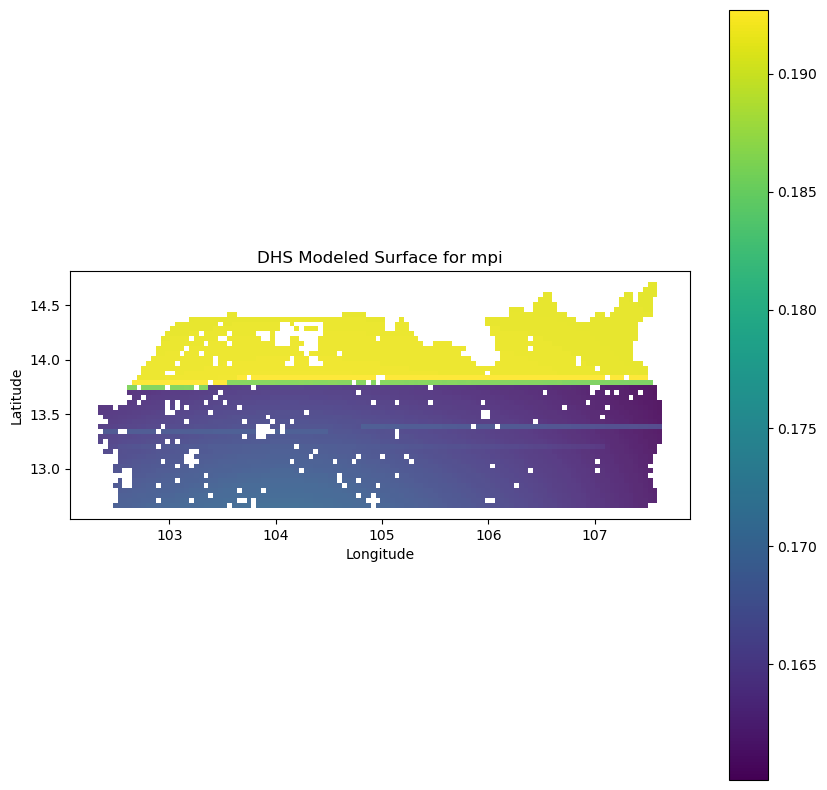

In [75]:
import matplotlib.pyplot as plt
import os

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a colormap based on the target_indicator
gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.8)

# Customize the plot (optional)
ax.set_title(f'DHS Modeled Surface for {target_indicator}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.5, legend=True)

# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'{country} - {year} -  {target_indicator} Predictions.pdf'))

plt.show()

<Axes: >

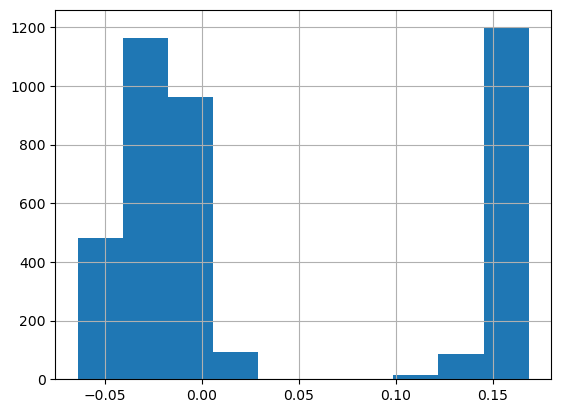

In [76]:
df['mpi_untransformed'].hist()

<Axes: >

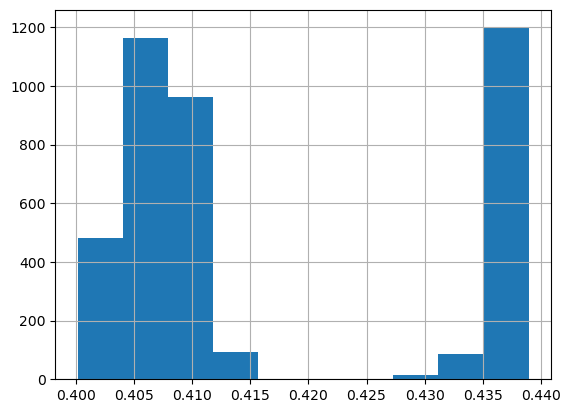

In [77]:
df['mpi_denormalized'].hist()

<Axes: >

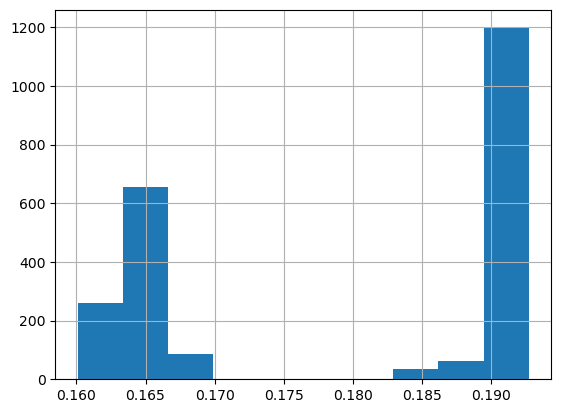

In [27]:
df['mpi'].hist()

In [28]:
report['Transformation Applied']

'sqrt'

### Uncertainty maps

Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.